In [62]:
from albumentations import (
    CLAHE, Blur, HueSaturationValue, GaussNoise, MotionBlur, MedianBlur, RandomBrightness, 
    Flip, OneOf, Compose, DualTransform, RandomGamma, Compose,  RandomBrightnessContrast, RandomGamma, 
    RandomBrightness, GaussNoise, MotionBlur, MedianBlur, Blur, HueSaturationValue, RandomFog, RandomRain
)
import os, shutil
import cv2

In [60]:
# Define the augmentations
train_augmentations = Compose([
    CLAHE(clip_limit=2),
    OneOf([
        RandomBrightnessContrast(p=0.4),
        RandomGamma(gamma_limit=(50, 150), p=1)
    ], p=0.4),
    RandomBrightnessContrast(p=0.2),
    OneOf([
        GaussNoise(var_limit=(10, 20), p=1)
    ], p=0.4),
    OneOf([
        MotionBlur(p=1),
        MedianBlur(blur_limit=3, p=1),
        Blur(blur_limit=3, p=1),
    ], p=0.4),
    HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, alpha_coef=0.08, p=0.2),
    RandomRain(p=0.2),
])


In [69]:
# Directory paths
image_dir = './second_augmented/val/im1/'
label_dir = './second_augmented/val/label1/'
output_image_dir = './second_augmented/val/im1/'
output_label_dir = './second_augmented/val/label1/'

# Create output directories if they don't exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

# Process each file in the image directory
for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        # Load image
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply augmentations
        augmented_image = train_augmentations(image=image)['image']

        # Save augmented image
        augmented_image_path = os.path.join(output_image_dir, filename.split('.')[0] + '_augmented.png')
        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(augmented_image_path, augmented_image)

        # Duplicate label file
        label_path = os.path.join(label_dir, filename)
        if os.path.exists(label_path):
            new_label_path = os.path.join(output_label_dir, filename.split('.')[0] + '_augmented.png')
            shutil.copy(label_path, new_label_path)


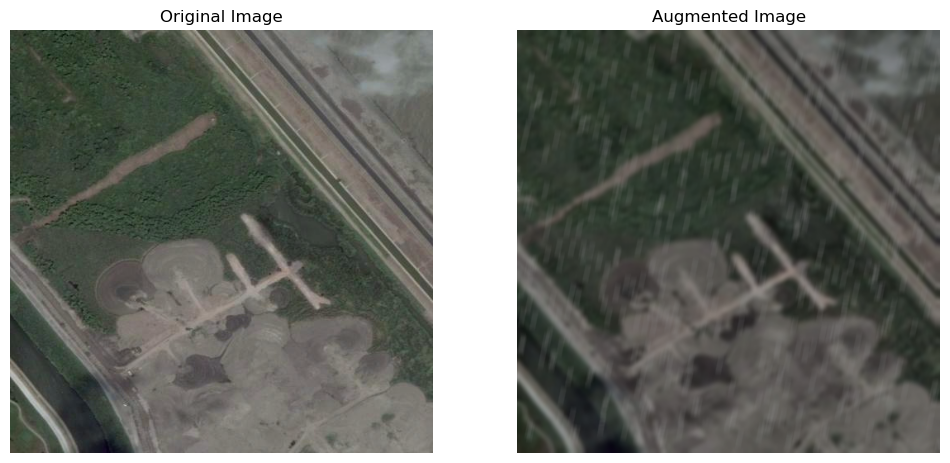

In [58]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('./second_dataset/train/im1/00003.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Apply augmentations
augmented_image = train_augmentations(image=image)['image']

# Display the original and augmented images
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(122)
plt.title('Augmented Image')
plt.imshow(augmented_image)
plt.axis('off')

plt.show()

In [ ]:
train_augmenter = Compose(train_augmentations, p=1)


# new targets function
def new_tf_targets(self):
    def augment_images(images, **params):
        aug_images = [self.apply(image, **params) for image in images]
        
        return aug_images
        
    def apply_to_mask_(mask, **params):
        aug = self.apply_to_mask(mask)
        
        if aug.ndim==2:
            aug = aug[:,:,None]
        return aug
    
    return {
        'image': self.apply, # do not rename this one
        'image2': self.apply, # do not rename this one
        'mask': apply_to_mask_,
        'bboxes': self.apply_to_bboxes
    }

# redefine targets function
# don't forget to wrap it in property
DualTransform.targets = property(new_tf_targets)